In [2]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import timeit 
import torch.nn.functional as F
from tqdm import tqdm
import cv2

In [3]:
#!pip install sporco
from sporco import array,plot,util

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load alaska postack image**

In [9]:
def mirror_padding(image, top_padding, bottom_padding, left_padding, right_padding):
    h, w = image.shape
    new_h = h + top_padding + bottom_padding
    new_w = w + left_padding + right_padding
    padded_image = np.zeros((new_h, new_w), dtype=image.dtype)
    
    padded_image[top_padding:top_padding + h, left_padding:left_padding + w] = image
    
    if top_padding > 0:
        padded_image[:top_padding, left_padding:left_padding + w] = image[:top_padding][::-1]
    
    if bottom_padding > 0:
        padded_image[top_padding + h:, left_padding:left_padding + w] = image[-bottom_padding:][::-1]
    
    if left_padding > 0:
        padded_image[top_padding:top_padding + h, :left_padding] = image[:, :left_padding][:, ::-1]
    
    if right_padding > 0:
        padded_image[top_padding:top_padding + h, left_padding + w:] = image[:, -right_padding:][:, ::-1]
    
    if top_padding > 0 and left_padding > 0:
        padded_image[:top_padding, :left_padding] = image[:top_padding, :left_padding][::-1, ::-1]
    
    if top_padding > 0 and right_padding > 0:
        padded_image[:top_padding, left_padding + w:] = image[:top_padding, -right_padding:][::-1, ::-1]
    
    if bottom_padding > 0 and left_padding > 0:
        padded_image[top_padding + h:, :left_padding] = image[-bottom_padding:, :left_padding][::-1, ::-1]
    
    if bottom_padding > 0 and right_padding > 0:
        padded_image[top_padding + h:, left_padding + w:] = image[-bottom_padding:, -right_padding:][::-1, ::-1]
    
    return padded_image
def padding(img):
    padd_img = img
    if (img.shape[0] % 128 != 0):
        pad = math.ceil(img.shape[0]/128)*128 - img.shape[0]
        if pad%2==0:
            top = pad/2
            bot = pad/2
        else:
            top = math.ceil(pad/2)
            bot = math.floor(pad/2)
        padd_img = mirror_padding(img,top,bot,0,0)
        if (img.shape[1] % 128 != 0):
            pad = math.ceil(img.shape[1]/128)*128 - img.shape[1]
            if pad%2==0:
                lf = pad/2
                rt = pad/2
            else:
                lf = math.ceil(pad/2)
                rt = math.floor(pad/2)
            padd_img = mirror_padding(padd_img,0,0,lf,rt)
        return padd_img, top, bot, lf, rt
    else:
        return padd_img, 0, 0, 0, 0

the shape is:  (640, 384)


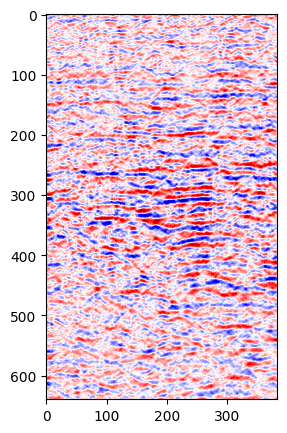

In [28]:
original = np.load('datasets/alaska_poststack_exp2.npy')
original = (original - np.min(original))/(np.max(original) - np.min(original))

TestData, top, bot, lf, rt = padding(original)

plt.figure(figsize=(7,5))
plt.imshow(TestData,cmap='seismic')

print('the shape is: ', TestData.shape)

In [11]:
singleffid = TestData.copy()
blksz = (128,128)
stpsz = (32,32)
blcks_corrupt = array.extract_blocks(singleffid, blksz, stpsz)
blcks_non_corrupt = array.extract_blocks(TestData, blksz, stpsz)

In [12]:
subblcks_corrupt = blcks_corrupt.transpose(2,0,1)
subblcks_non_corrupt = blcks_non_corrupt.transpose(2,0,1)
subblcks_non_corrupt = torch.from_numpy(subblcks_non_corrupt).unsqueeze(1)
subblcks_corrupt = torch.from_numpy(subblcks_corrupt).unsqueeze(1)

**Import model and load weights**

In [13]:
from models.Attention_unet import AttU_Net

In [14]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('checkpoints/att_u_fine.pt'))

<All keys matched successfully>

In [15]:
subblcks_corrupt.shape

torch.Size([153, 1, 128, 128])

**EXP 1 : RECONSTRUCTION ALASKA POSTSTACK IMAGE**

In [16]:
data_loader = torch.utils.data.DataLoader(subblcks_corrupt, batch_size=40)

In [17]:
denoised_tensor_list = []
for batch in tqdm(data_loader):
    with torch.no_grad():
        denoised_batch = model(batch.to(device))
        denoised_tensor_list.append(denoised_batch.cpu())
recov_blcks = torch.cat(denoised_tensor_list, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]


In [18]:
recov_blcks = recov_blcks.cpu().numpy().transpose(0,2,3,1)
subblcks_corrupt = subblcks_corrupt.numpy().transpose(0,2,3,1)
subblcks_non_corrupt = subblcks_non_corrupt.numpy().transpose(0,2,3,1)

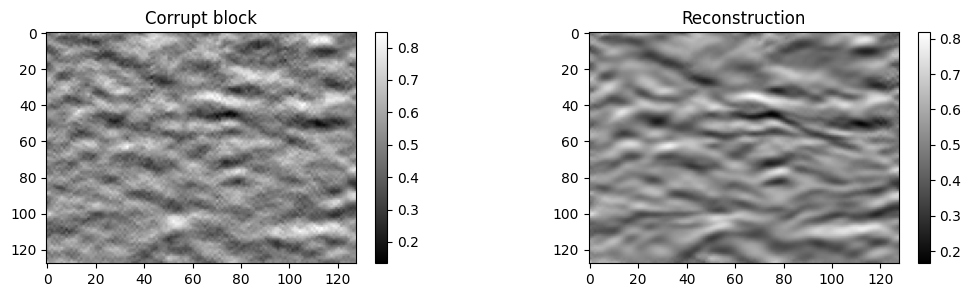

In [19]:
kk =100
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(subblcks_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), #plt.clim([0.5,0.64])
plt.colorbar()

plt.title("Corrupt block")

plt.subplot(122)
plt.imshow(recov_blcks[kk,:,:,0],aspect='auto',cmap='gray'), 
plt.colorbar()
plt.title("Reconstruction")


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [20]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [21]:
start = timeit.default_timer()
#imgd_median = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)
print("creating image from patching, time is:",
              timeit.default_timer() - start)

creating image from patching, time is: 5.5764080999999805


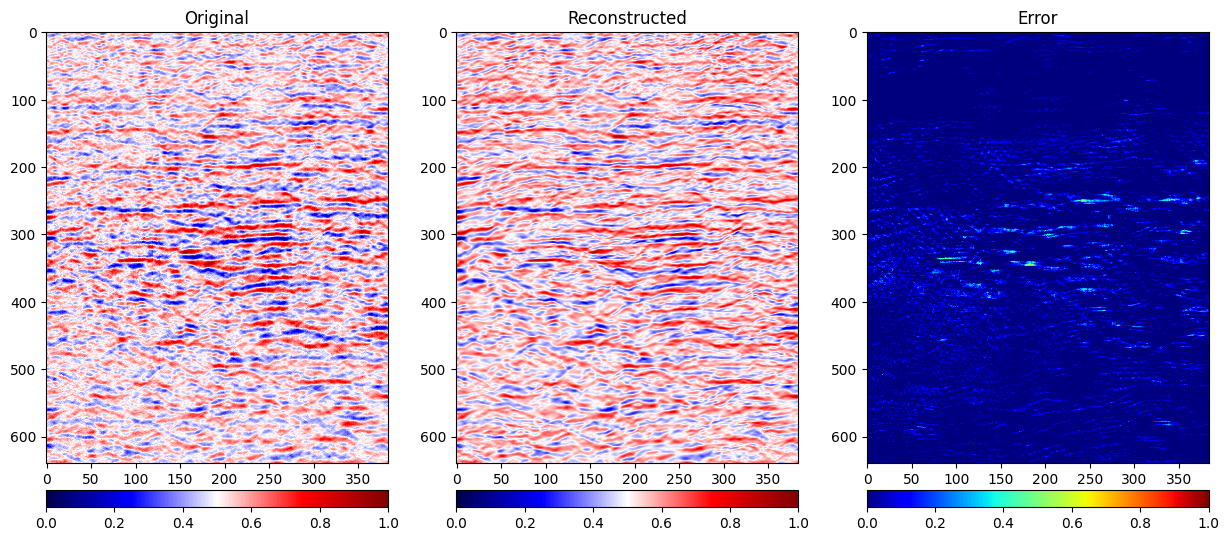

In [32]:
plt.figure(figsize=(15,7))

err = original-imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt]
err /= np.max(np.abs(err))

plt.subplot(131)
plt.imshow(original,aspect='auto',cmap='seismic')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt],aspect='auto',cmap='seismic'), plt.clim([0,1])
plt.title('Reconstructed')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(133)
plt.imshow(err,aspect='auto',cmap='jet'),
plt.clim([0,1])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.savefig('alaska_2D_reconstructed.jpg', bbox_inches='tight')
plt.show()

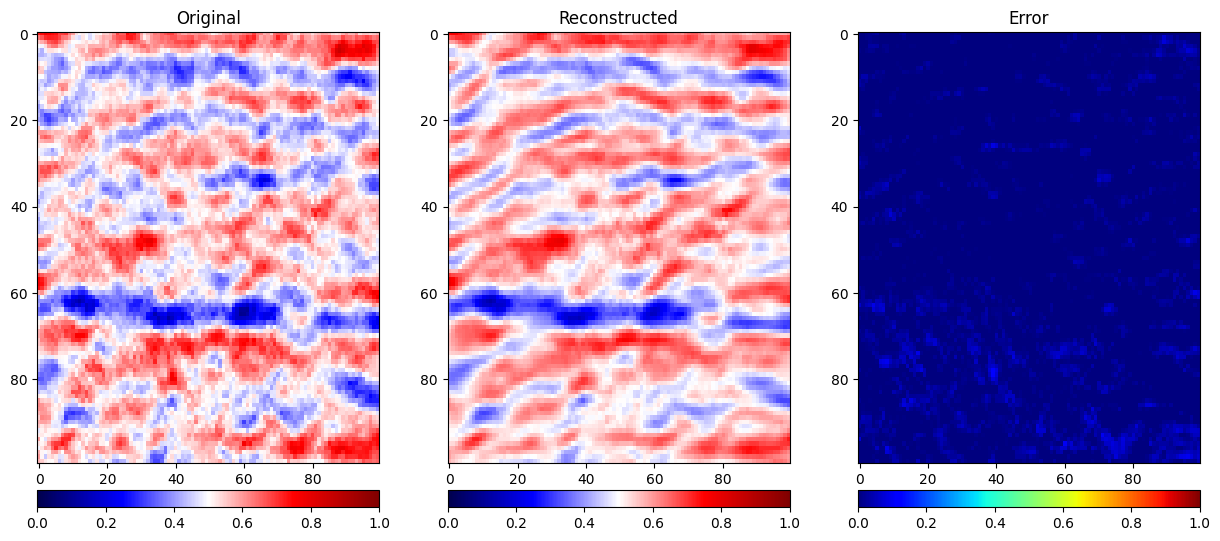

In [38]:
err_section = TestData[200:300,50:150]-imgd_median[200:300,50:150]

plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(TestData[200:300,50:150],aspect='auto',cmap='seismic')
plt.title('Original')
plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.subplot(132)
plt.imshow(imgd_median[200:300,50:150],aspect='auto',cmap='seismic'), plt.clim([0,1]),plt.colorbar(orientation='horizontal',pad=0.05)
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(err_section,aspect='auto',cmap='jet'),
plt.clim([0,1])
plt.title('Error')
plt.colorbar(orientation='horizontal',pad=0.05)
plt.show()

**Fast Noise variance Estimation**

In [24]:
import math
def estimate_noise(I):

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  I= torch.from_numpy(I).float()
  M=np.array(M)
  M=torch.from_numpy(M).float()
  imgFiltered = F.conv2d(I.unsqueeze(0).unsqueeze(0), M.unsqueeze(0).unsqueeze(0), padding=1)
  x=imgFiltered.numpy()
  sigma = np.sum(np.sum(np.absolute(x)))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return sigma
print("Noisy image:",estimate_noise(TestData))
print("Denoised image:",estimate_noise(imgd_median))

Noisy image: 0.01659721862055524
Denoised image: 0.004843377726034104
